In [231]:
from pruneshift.datamodules import ShiftDataModule
from pruneshift.networks import create_network
from pruneshift.teachers import create_teacher
from pruneshift.teachers import Teacher
from crd.criterion import CRDLoss

import random
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from pytorch_lightning.metrics.functional import accuracy


path = "/misc/scratchSSD2/datasets/ILSVRC2012-100/"
amda_path = "/misc/lmbraid19/hoffmaja/models/imagenetr_models/deepaugment_and_augmix.pth.tar"
data_swsl_path = "/misc/lmbraid19/hoffmaja/data_swsl_resnet50.pt"
data_amda_path = "/misc/lmbraid19/hoffmaja/data_amda_resnet50.pt"

In [256]:
data_amda = create_teacher(num_classes=100, activations_path=data_amda_path, imagenet_subset=True)
data_swsl = create_teacher(num_classes=100, activations_path=data_swsl_path, imagenet_subset=True)

In [3]:
net_amda = create_network("imagenet", "resnet50", 100, ckpt_path=amda_path, imagenet_subset=True)
net_swsl = create_network("imagenet", "swsl_resnet50", 100, download=True, imagenet_subset=True)
net_amda = net_amda.eval()
net_swsl = net_swsl.eval()

In [4]:
dm_train = ShiftDataModule("imagenet", path)
dm_train.setup("fit")
# dm_test = ShiftDataModule("imagenet", path, only_test_transform=True)
# dm_test.setup("fit")

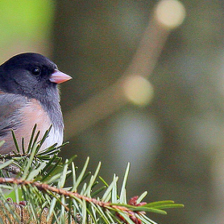

10027


In [258]:
idx = random.choice(range(len(dm_train.train_dataset.dataset)))
x, y = dm_train.train_dataset.dataset[idx]
x = dm_train.train_transform(x)
display(x)
print(idx)
x = dm_train.normalize(x)

In [259]:
def plot_soft_target(net, sample, idx, T, database=False):
    if database:
        pred = net(torch.tensor(idx), sample[None, ...])
        probs = torch.softmax(pred / T, 0)
    else:
        probs = torch.softmax(net(sample[None, ...] / T), 1).detach().cpu().numpy().flatten()
    idx = range(len(probs))
    fig = plt.bar(idx, probs, width=100/len(probs))
    plt.yscale("log")
    


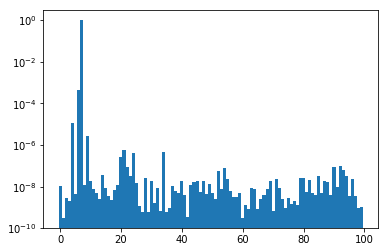

In [260]:
plot_soft_target(net_swsl, x, torch.tensor(idx), 20)

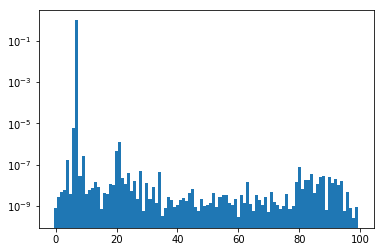

In [261]:
plot_soft_target(net_amda, x, idx, 4)

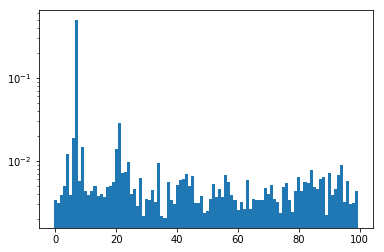

In [262]:
plot_soft_target(data_amda, x, idx, 4, database=True)

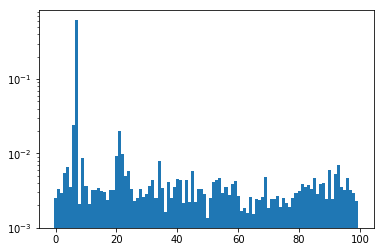

In [263]:
plot_soft_target(data_swsl, x, idx, 4, database=True)

In [234]:
type(data_swsl)

pruneshift.networks.ImagenetSubsetWrapper

In [209]:
y

97

In [ ]:
, x, y = dm_train.train_dataset[idx]
y_train = torch.softmax(net(x[None, ...] / T), 1).detach().cpu().numpy().flatten()
_, x, y = dm_test.train_dataset[idx]
y_test = torch.softmax(net(x[None, ...] / T_database), 1).detach().cpu().numpy().flatten()

In [9]:
idx = 100002
T = 1
T_database = 1
_, x, y = dm_train.train_dataset[idx]
y_train = torch.softmax(net(x[None, ...] / T), 1).detach().cpu().numpy().flatten()
_, x, y = dm_test.train_dataset[idx]
y_test = torch.softmax(net(x[None, ...] / T_database), 1).detach().cpu().numpy().flatten()

In [10]:
def plot(probs):
    idx = range(len(probs))
    fig = plt.bar(idx, probs, width=100/len(probs))
    plt.yscale("log")

In [11]:
print(np.sum(-y_train * np.log(y_train)))
print(np.sum(-y_test * np.log(y_test)))

0.05817272
0.6659622


In [13]:
y_train - y_test

array([ 5.46448353e-09,  5.26393096e-10,  1.73448894e-10,  3.20214113e-08,
        8.63877148e-08, -2.48909604e-09, -5.66310554e-08, -2.65803135e-09,
       -2.17359108e-09, -2.80660317e-09, -8.12663643e-08,  1.18459916e-07,
       -8.41167758e-09, -1.83224707e-08, -7.28523233e-08, -3.54369513e-06,
       -1.05643778e-08,  2.12412399e-09,  1.65844849e-09,  5.96492855e-09,
       -4.19235313e-10, -6.45786624e-09,  2.22181296e-09,  1.53248181e-09,
       -8.32546032e-10, -3.15045490e-10, -1.63183316e-08,  9.49724122e-09,
        1.47433488e-08,  3.15603899e-08,  8.15993051e-09,  1.82289739e-11,
        5.38232792e-11,  6.02505268e-11, -3.27061489e-09,  7.43685558e-09,
        6.40279030e-09,  8.64020677e-08, -1.32744432e-07, -1.08423648e-09,
       -8.90672567e-08, -5.35894884e-09, -4.38146763e-09, -1.79642257e-07,
       -2.19903811e-08, -4.83798512e-09, -2.66720535e-09, -4.91807484e-08,
       -9.98286254e-09, -1.31939766e-08, -2.73142620e-09, -2.16512419e-07,
       -1.73487180e-08, -

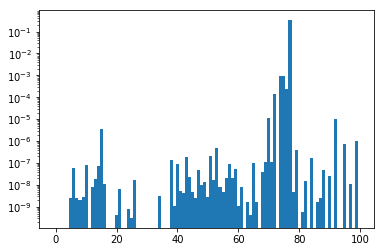

In [18]:
plot(y_test - y_train)

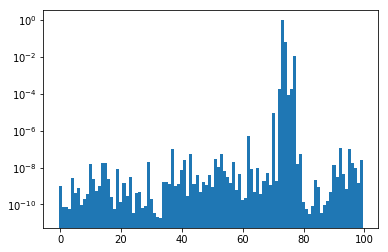

In [119]:
plot(y_train)

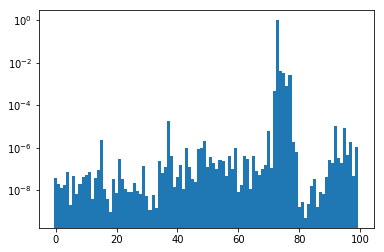

In [120]:
plot(y_test)

In [3]:
import random

def calculate_entropy(dataset, net, n=100, T=4):
    """ Averages the entropy over the first n samples."""
    samples = []
    print("Loading samples...")
    for _ in tqdm(range(n)):
        _, x, _ = random.choice(dataset)
        samples.append(x)
    batch =  torch.stack(samples)
    print("Bring net to a cuda device...")
    net = net.to(torch.device("cuda:1"))
    batch = batch.to(torch.device("cuda:1"))
    print("Forward pass...")
    pred = net(batch)
    print("Calculate stats...")
    prob = torch.softmax(pred * T, 1).detach().cpu()
    log_prob = torch.log_softmax(pred * T, 1).detach().cpu()
    return (-prob * log_prob).sum(1).mean()

In [ ]:
calculate_entropy(dm_train.train_dataset, net)

Loading samples...



Bring net to the a cuda device...


In [126]:
calculate_entropy(dm_test.train_dataset, net, 200)

tensor(0.0202)